<a href="https://colab.research.google.com/github/raceregos/raceregos/blob/main/myWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Job Group Distribution:
 job_group
Data/AI        1345
Engineering    1179
Business       1008
Software        505
HR              338
Other           337
Name: count, dtype: int64

SVM Model Performance Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

SVM Classification Report:
               precision    recall  f1-score   support

    Business       1.00      1.00      1.00       302
     Data/AI       1.00      1.00      1.00       404
 Engineering       1.00      1.00      1.00       354
          HR       1.00      1.00      1.00       101
       Other       1.00      1.00      1.00       101
    Software       1.00      1.00      1.00       152

    accuracy                           1.00      1414
   macro avg       1.00      1.00      1.00      1414
weighted avg       1.00      1.00      1.00      1414



<Figure size 1000x800 with 0 Axes>

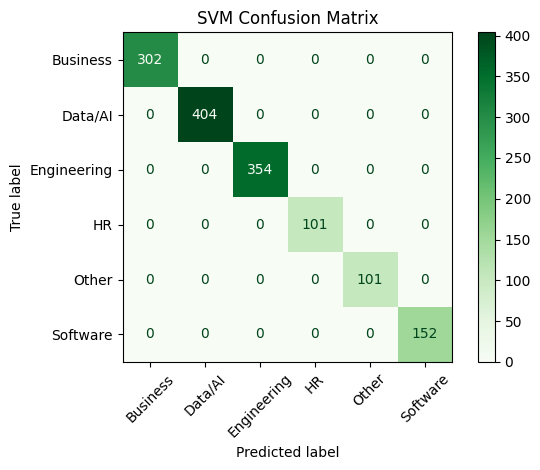

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import LinearSVC

# Ensure necessary resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Cleans text by removing special characters, converting to lowercase,
    removing stopwords, and applying lemmatization.
    """
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Load dataset
df = pd.read_csv('resume_data.csv')
df.columns = df.columns.str.replace('\ufeff', '')  # Remove BOM if present

# Drop rows with missing values in key text columns
df = df.dropna(subset=['job_position_name', 'career_objective', 'skills'])

# Convert 'skills' column from list-like string to space-separated text
df['skills'] = df['skills'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else '')

# Fill missing values for additional text fields
for col in ['responsibilities', 'positions', 'related_skils_in_job']:
    if col in df.columns:
        df[col] = df[col].astype(str).fillna('')

# Combine textual fields for text classification
df['full_text'] = (
    df['career_objective'] + ' ' +
    df['skills'] + ' ' +
    df['responsibilities'] + ' ' +
    df['positions'] + ' ' +
    df['related_skils_in_job']
)

# Apply text preprocessing
df['full_text'] = df['full_text'].apply(clean_text)

# Job grouping function
def group_job(title):
    title = title.lower()
    if any(x in title for x in ['hr', 'human resource', 'recruiter']):
        return 'HR'
    elif any(x in title for x in ['business', 'consultant', 'executive', 'finance', 'marketing']):
        return 'Business'
    elif any(x in title for x in ['data', 'ai', 'ml', 'scientist', 'analytics']):
        return 'Data/AI'
    elif any(x in title for x in ['software', 'developer', 'ios', 'android', 'backend', 'frontend']):
        return 'Software'
    elif any(x in title for x in ['civil', 'mechanical', 'electrical', 'engineer']):
        return 'Engineering'
    elif any(x in title for x in ['product manager', 'project manager']):
        return 'Management'
    else:
        return 'Other'

df['job_group'] = df['job_position_name'].apply(group_job)

# Print job group distribution
print("Job Group Distribution:\n", df['job_group'].value_counts())

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['job_group'])
X = df['full_text']

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=10000,  # Increased feature count
    ngram_range=(1, 3),  # Capture more context
    max_df=0.9,
    min_df=2
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Apply undersampling for balance
undersampler = RandomUnderSampler(random_state=42)
X_train_tfidf_resampled, y_train_resampled = undersampler.fit_resample(X_train_tfidf_resampled, y_train_resampled)
'''
# Hyperparameter tuning for KNN: Finding the best k
best_k = 3
best_score = 0
for k in range(3, 35, 2):  # Expanded range
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(X_train_tfidf_resampled, y_train_resampled)
    score = knn.score(X_test_tfidf, y_test)
    if score > best_score:
        best_score = score
        best_k = k

print(f"Optimal K: {best_k}")

# Train final KNN model with optimal k
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric='cosine')
knn_final.fit(X_train_tfidf_resampled, y_train_resampled)

# Predict on the test set
y_pred = knn_final.predict(X_test_tfidf)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
'''
from sklearn.svm import LinearSVC

# Train an SVM classifier
svm = LinearSVC()
svm.fit(X_train_tfidf_resampled, y_train_resampled)

# Predict on the test set
y_pred_svm = svm.predict(X_test_tfidf)

# Evaluation
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred_svm, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred_svm, average='macro', zero_division=0)

print("\nSVM Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_, zero_division=0))

# Confusion Matrix for SVM
cm = confusion_matrix(y_test, y_pred_svm, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Greens")
plt.title("SVM Confusion Matrix")
plt.tight_layout()
plt.show()
